**Unzip data**

In [26]:
import os
import py7zr

In [2]:
'''

zip_path='Handwritten.7z'
extract_path='Handwritten_equations'

with py7zr.SevenZipFile(zip_path,'r') as zip_ref:
    zip_ref.extractall(extract_path)

''' 

"\n\nzip_path='Handwritten.7z'\nextract_path='Handwritten_equations'\n\nwith py7zr.SevenZipFile(zip_path,'r') as zip_ref:\n    zip_ref.extractall(extract_path)\n\n"

**Making Charector Dictionary**

In [9]:
import torch
import torch.nn as nn
import pandas as pd
from PIL import Image
from torchvision import transforms,datasets
from torch.utils.data import Dataset , DataLoader

In [10]:
image_folder="Handwritten_equations/Handwritten/Dataset"
df=pd.read_csv('caption_data.csv')

In [11]:
import json

# Extract all characters from the labels
all_text = "".join(df["Column2"].astype(str))  # Convert all text into a single string

# Get unique characters and create dictionary
unique_chars = sorted(set(all_text))
char_dict = {char: idx for idx, char in enumerate(unique_chars)}

# Save dictionary for later use
with open("char_dict.json", "w", encoding="utf-8") as f:
    json.dump(char_dict, f, indent=4, ensure_ascii=False)

print("Character dictionary created")


Character dictionary created


In [12]:
df.sample(5)
value = df.loc[df['Column1'] == '29_em_167', df.columns[1]].values[0]
print(value)

\cos ( n x ) = 2 \cos ( x ) \cos [ ( n - 1 ) x ] - \cos [ ( n - 2 ) x ]


**Encoding labels**

In [13]:
# Encoding of Latex labels
def encode_label(label, char_dict):
    return [char_dict[char] for char in label if char in char_dict]

df["Column2"] = df["Column2"].apply(lambda x: encode_label(x, char_dict))

print("Example encoded label:", df["Column2"].iloc[0])


Example encoded label: [70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 70, 0, 70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 5, 0, 71, 0, 46, 0, 73, 0, 57, 0, 75, 0, 71, 0, 70, 0, 46, 0, 73, 0, 57, 0, 75]


In [14]:
df.head()

,Column1,Column2
0,18_em_0,"[70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 70, 0, 70,..."
1,18_em_10,"[12, 0, 16]"
2,18_em_11,"[63, 0, 46, 0, 73, 0, 66, 0, 75, 0, 21, 0, 12,..."
3,18_em_12,"[43, 52, 64, 47, 49, 0, 73, 0, 62, 0, 51, 0, 4..."
4,18_em_13,"[14, 0, 45, 0, 73, 0, 12, 0, 75, 0, 5, 0, 14, ..."


**Matching the name of image**

In [15]:
# Modyfing the name of images
df["Column1"] = df["Column1"].astype(str) + ".bmp"
df.head()

,Column1,Column2
0,18_em_0.bmp,"[70, 0, 46, 0, 73, 0, 57, 0, 75, 0, 70, 0, 70,..."
1,18_em_10.bmp,"[12, 0, 16]"
2,18_em_11.bmp,"[63, 0, 46, 0, 73, 0, 66, 0, 75, 0, 21, 0, 12,..."
3,18_em_12.bmp,"[43, 52, 64, 47, 49, 0, 73, 0, 62, 0, 51, 0, 4..."
4,18_em_13.bmp,"[14, 0, 45, 0, 73, 0, 12, 0, 75, 0, 5, 0, 14, ..."


**Dataset class**

In [16]:
class Dataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        print("Initial DataFrame size:", len(self.df))

        # Filter out rows where the image does not exist
        self.df = self.df[self.df.iloc[:, 0].apply(lambda x: os.path.exists(os.path.join(img_dir, x)))].reset_index(drop=True)

        print("Final DataFrame size:", len(self.df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img_name = self.df.iloc[index, 0]
        img_path = os.path.join(self.img_dir, img_name)

        
        image = Image.open(img_path)

        label = self.df.iloc[index, -1]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, label
        

**Dataset**

In [17]:
# This transforms this image to tensor

mean=[0.4363]
std=[0.2129]
transform=transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128,128)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

# Create dataset
dataset=Dataset(df=df,img_dir=image_folder,transform=transform)

Initial DataFrame size: 12167
Final DataFrame size: 12167


**Managing the variable lenght**

In [18]:
# Manage the variable lenght of label

def custom_collate_fn(batch):
    images, labels = zip(*batch)  # Unzip images and labels

    # Stack images into a batch tensor
    images = torch.stack(images, dim=0)

    # Convert each label tensor to a list (to allow list operations)
    labels = [label.tolist() if isinstance(label, torch.Tensor) else label for label in labels]

    # Find max length of label in the batch
    max_len = max(len(label) for label in labels)

    # Pad labels with 0 (or another padding token if needed)
    padded_labels = [label + [0] * (max_len - len(label)) for label in labels]

    # Convert labels to tensor
    labels_tensor = torch.tensor(padded_labels, dtype=torch.long)

    return images, labels_tensor  # Labels are now a padded tensor


**Use of DataLoader**

In [19]:
from torch.utils.data import random_split
train_ratio=0.8
train_size=int(train_ratio*len(dataset))
test_size=len(dataset)-train_size

train_data,test_data=random_split(dataset,[train_size,test_size])

In [20]:
batch_size=8
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True,pin_memory=True,collate_fn=custom_collate_fn)
test_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,pin_memory=True,collate_fn=custom_collate_fn)

**Visulisation of one tensor from test**

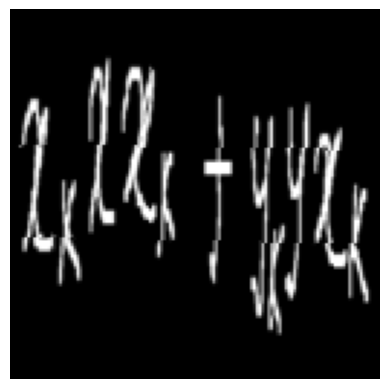

Label (LaTeX format): tensor([70,  0, 46,  0, 73,  0, 57,  0, 75,  0, 70,  0, 70,  0, 46,  0, 73,  0,
        57,  0, 75,  0,  5,  0, 71,  0, 46,  0, 73,  0, 57,  0, 75,  0, 71,  0,
        70,  0, 46,  0, 73,  0, 57,  0, 75,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0])
Images Tensor Shape: (128, 128, 1)
Labels Tensor Shape: torch.Size([61])


In [21]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch

# Get one batch from the DataLoader
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Get first batch

# Select the first image from the batch
image = images[0]  # First image tensor

# Convert tensor to numpy for visualization
image = image.permute(1, 2, 0).cpu().numpy()  # Convert (C, H, W) to (H, W, C)

# Display the image
plt.imshow(image, cmap="gray")  # Use 'gray' if it's a grayscale image
plt.axis("off")
plt.show()

# Print the corresponding label
print("Label (LaTeX format):", labels[0])
print(f"Images Tensor Shape: {image.shape}")  # Should be (batch_size, 3,resize,resize)
print(f"Labels Tensor Shape: {labels[0].shape}")  # Should be (batch_size,)

<font size='5'>**Done making train and test data set now make model and train**</font>

In [38]:
class Model(nn.Module):
    def __init__(self, input_features=1):  # Default to 1 channel
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_features, 64, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)           
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.4),

            nn.Linear(64, 8)
        )


    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [39]:
lr=0.01
epochs=100

In [40]:
import torch.optim as op

model=Model(1)
Cross_Loss=nn.CrossEntropyLoss()
opt=op.SGD(model.parameters(),lr=lr,momentum=0.8)

In [41]:
for i, (batch_features, batch_labels) in enumerate(train_loader):
    out = model.forward(batch_features)
    print(out)
    if i == 3:  # Stop after the second batch (i starts at 0)
        break


tensor([[ 0.2349,  0.0228,  0.3975, -0.1458, -0.5436,  0.3543, -0.1258, -0.0448],
        [ 0.1404,  0.3031,  0.1715, -0.1537, -0.1863, -0.1560,  0.1065, -0.2072],
        [-0.0803, -0.1985,  0.1333,  0.1268, -0.3663, -0.1833,  0.1676, -0.3279],
        [-0.0437, -0.0538,  0.1787, -0.2693, -0.0110,  0.1664,  0.3237, -0.0758],
        [-0.2488,  0.0130,  0.0166,  0.1293,  0.4397, -0.2578, -0.2941, -0.1477],
        [-0.1612,  0.5370,  0.1555, -0.2561,  0.3796,  0.1108, -0.1502, -0.0590],
        [-0.1537,  0.1772,  0.2150, -0.4789, -0.6481,  0.0191, -0.3213, -0.2552],
        [-0.3263,  0.0224,  0.3252, -0.0978, -0.1341, -0.0523, -0.4023,  0.1794]],
       grad_fn=<AddmmBackward0>)
tensor([[-0.0743,  0.4757,  0.0660,  0.1037,  0.2652,  0.1158, -0.5591,  0.1372],
        [ 0.1454,  0.3010, -0.1660, -0.0469, -0.1681, -0.0217,  0.0915,  0.1153],
        [-0.2613,  0.1693, -0.0740, -0.2739, -0.4291, -0.0884, -0.4308, -0.2682],
        [ 0.0368,  0.1773, -0.2322, -0.0783,  0.0271,  0.1688,  

In [18]:
import time
loss_values=[]
for epoch in range(epochs):
    start=time.time()
    total_loss=0
    for batch_features,batch_labels in train_loader:

        batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)

        out=model.forward(batch_features)
        loss=Cross_Loss(out,batch_labels)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss+=loss.item()

    avg_loss=total_loss/len(train_loader)
    end=time.time()
    print(f'Epoch: {epoch+1} and avg_loss: {avg_loss} and time: {end-start}')
    loss_values.append(avg_loss)

KeyboardInterrupt: 

In [ ]:
model.eval()

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_values,  linestyle='-', color='b', label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.grid()
plt.show()